,Close-BTC,Close-BNB,Close-ADA
Close-BTC,1.000000000000,0.365375573231,0.747022972917
Close-BNB,0.365375573231,1.000000000000,0.531744535526
Close-ADA,0.747022972917,0.531744535526,1.000000000000


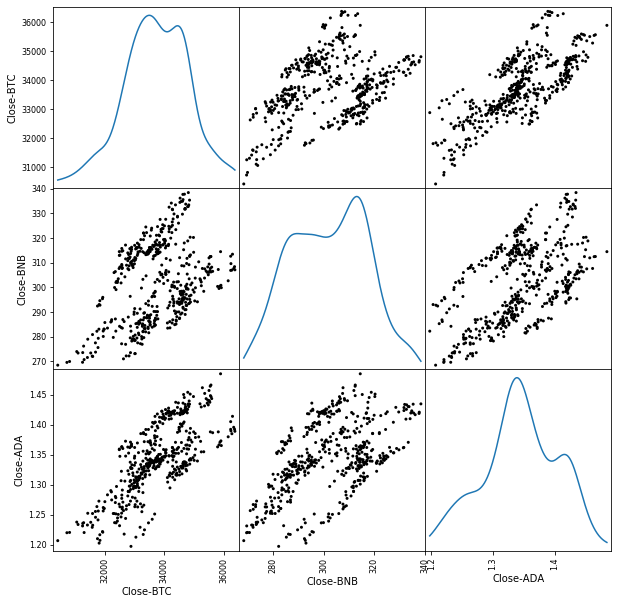

In [37]:
import pandas as pd
import numpy as np
from tzlocal import get_localzone
import requests
import json
from datetime import datetime
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.core.display import display, HTML

# Notebook settings
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100)
pd.set_option('mode.chained_assignment', None)
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))
pd.set_option("precision", 12)
mytz = get_localzone()

def load_data_from_binance(coin_pair, time_interval):
    resp = requests.get('https://www.binance.com/api/v3/klines?symbol=' + coin_pair + '&interval=' + time_interval)
    df = pd.DataFrame(json.loads(resp.text))
    df = df[[0, 1, 2, 3, 4, 5]]
    df = df.rename(columns = { 0: 'Date', 1: 'Open', 2: 'High', 3: 'Low', 4: 'Close', 5: 'Volume' })

    df['High'] = df['High'].astype(float)
    df['Low'] = df['Low'].astype(float)
    df["Close"] = df['Close'].astype(float)
    df['Open'] = df['Open'].astype(float)
    df['Volume'] = df['Volume'].astype(float)
    df['Date'] =  pd.to_datetime(df['Date'], unit='ms').dt.tz_localize('UTC').dt.tz_convert(mytz).dt.strftime('%Y-%m-%d %H')
    df = df.set_index(pd.DatetimeIndex(df['Date']))

    return df

def merge_dfs(options):
    return options['dfa']['df'].join(
        options['dfb']['df'],
        how='outer',
        lsuffix=options['dfa']['suffix']).join(
        options['dfc']['df'],
        how='outer',
        lsuffix=options['dfb']['suffix'],
        rsuffix=options['dfc']['suffix'])


def fetch_close_price(a, b, c, base, time_interval): 
    df_a = load_data_from_binance(a + base, time_interval)
    df_b = load_data_from_binance(b + base, time_interval)
    df_c = load_data_from_binance(c + base, time_interval)
    
    return {
        'dfa': {
            'df': df_a[['Close']], 
            'suffix': '-' + a
        },
        'dfb': {
            'df': df_b[['Close']],
            'suffix': '-' + b
        },
        'dfc': {
            'df': df_c[['Close']],
            'suffix': '-' + c
        }
    }
    
dfs = fetch_close_price('BTC', 'BNB', 'ADA', 'USDT', '1h')
df_merged = merge_dfs(dfs)
pd.plotting.scatter_matrix(df_merged, figsize=(10, 10), color='black', alpha=1, diagonal='kde', grid=True)
df_merged.corr()

# At the time I run this code, the 3 coins (BTC, BNB, and ADA) were normally distributed. 
# BNB reacts less to BTC price changes. I can be appreciated because the bell patter differs from the BTC.
# ADA, however, follows more closely the BTC bell pattern which indicates a higher correlation.